In [1]:
exec(open("../../header.py").read())

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

from transformers import BertTokenizer,BertModel
from datasets import load_from_disk,load_dataset

import matplotlib.pyplot as plt

In [3]:
class EncodedSegmentsDataset(Dataset):
    def __init__(self,data_list):
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
 
    def __getitem__(self,idx):
        return(self.data_list[idx])
    
class LSTMoverBERT(nn.Module):
    def __init__(self):
        super().__init__()
        self.LSTM = nn.LSTM(input_size=768,hidden_size = 128,num_layers=1,batch_first=True)
        self.activation = nn.ReLU()
        self.linear1 = nn.Linear(in_features=128,out_features=64)
        self.linear2 = nn.Linear(in_features=64,out_features=20)
        self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x,verbose=False):
        
        #print('input x:', x.shape)
        LSTM_out,LSTM_states = self.LSTM(x)
        #print('LSTM out:', LSTM_out.shape)
        #print('LSTM states[0]:', LSTM_states[0].shape)
        #print('LSTM states[1]:', LSTM_states[1].shape)
        last_hidden_state = LSTM_states[0][0,:,:]
        #last_embedding = LSTM_out[:,-1,:]
        out = self.linear1(last_hidden_state)
        #print('linear out', out.shape) if verbose
        out = self.activation(out)
        #print('activation out', out.shape) if verbose
        out = self.linear2(out)
        out = self.softmax(out)
        return out



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print_cuda_info(device)

Using device: cuda
Quadro RTX 8000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Start of Model

In [10]:
os.listdir(EMBEDDINGS_DIR('20news/bert-base-uncased/train'))

['bert_encoded_segments_list_0.65.pkl',
 'bert_encoded_segments_list_1.0.pkl',
 'bert_encoded_segments_list_0.9.pkl',
 'bert_encoded_segments_list_0.999999.pkl',
 'bert_encoded_segments_list_0.99999.pkl',
 'bert_encoded_segments_list_0.97.pkl',
 'bert_encoded_segments_list_0.6.pkl',
 'bert_encoded_segments_list_0.98.pkl',
 'bert_encoded_segments_list_0.7.pkl',
 'bert_encoded_segments_list_0.96.pkl',
 'bert_encoded_segments_list_0.5.pkl',
 'bert_encoded_segments_list_0.8.pkl',
 'bert_encoded_segments_list_0.85.pkl',
 'bert_encoded_segments_list_0.99.pkl',
 'bert_encoded_segments_list_0.75.pkl',
 'bert_encoded_segments_list_0.9999.pkl',
 'bert_encoded_segments_list_0.55.pkl',
 'bert_encoded_segments_list_0.95.pkl',
 'bert_encoded_segments_list_0.999.pkl']

In [13]:
threshold = 1.0
processed_dir = EMBEDDINGS_DIR('20news/bert-base-uncased')
split='train'
file_name = 'bert_encoded_segments_list'

# Our experiment below
with open(f'{processed_dir}/{split}/{file_name}_{threshold}.pkl', 'rb') as handle:
    bert_encoded_segments_list = pickle.load(handle)


In [14]:
encoded_dataset = EncodedSegmentsDataset(bert_encoded_segments_list)
val_prop =.1
bsize = 1

dataset_size = len(encoded_dataset)
val_size = int(val_prop * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset =  torch.utils.data.random_split(encoded_dataset,[train_size,val_size])
encoded_train_loader = DataLoader(train_dataset,batch_size=bsize,shuffle=True, pin_memory=True)
encoded_val_loader = DataLoader(val_dataset,batch_size=bsize,shuffle=True, pin_memory=True)

In [15]:
LoBERT_model = LSTMoverBERT()
LoBERT_model.to(device)
LoBERT_model.train()
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(LoBERT_model.parameters(),lr=5e-4,)

num_epochs=100
# model_save_path = r'\\wsl$\Ubuntu-20.04\home\jolteon\NLUProject\models\best_threshold_'+str(threshold)+'_LoBERT.ckpt'
best_val_accuracy = 0



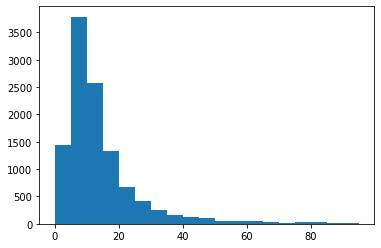

In [16]:
seg_length_list = []
for label, encoded_segments in bert_encoded_segments_list:
    seg_length_list.append(encoded_segments.shape[0])
plt.hist(seg_length_list,bins = np.arange(0,100,5))
plt.show()

In [17]:
train_loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []

for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
    train_loss = 0
    train_correct = 0
    val_loss = 0
    val_correct = 0
    
    #START TRAIN
    LoBERT_model.train()
    for idx, batch in enumerate(encoded_train_loader):
        optimizer.zero_grad()

        # Define and move to GPU
        label = batch[0][0]
        model_input = batch[1]
        label = label.to(device)
        model_input = model_input.to(device)
        # Forward Pass
        out = LoBERT_model(model_input)
        loss = criterion(out,label)
        #Record Metrics pt 1/2
        train_loss += loss.item()
        pred = torch.argmax(out)
        train_correct +=(pred == label).sum()
        
        #Backward pass
        loss.backward()
        optimizer.step()
    
    #Record Metrics pt 2/2
    train_loss = train_loss/ len(encoded_train_loader)
    train_accuracy = train_correct/len(encoded_train_loader)
    #Print and save
    print('Epoch:', epoch, 'train_loss:',train_loss, 'accuracy: ',train_accuracy)
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_accuracy.cpu())
    
    # START VAL
    LoBERT_model.eval()
    
    with torch.no_grad():
        for idx, batch in enumerate(encoded_val_loader):
            #Define and move to GPU
            label = batch[0][0]
            model_input = batch[1]
            label = label.to(device)
            model_input = model_input.to(device)
            #Forward Pass
            out = LoBERT_model(model_input)
            loss = criterion(out,label)
            #Record metrics pt 1/2
            val_loss += loss.item()

            pred = torch.argmax(out)
            val_correct +=(pred == label).sum()
            
    #Record metrics pt 2/2
    val_loss = val_loss/ len(encoded_val_loader)
    val_accuracy = val_correct/len(encoded_val_loader)
    #Print and save
    print('Epoch:', epoch, 'val_loss:',val_loss, 'accuracy: ',val_accuracy)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy.cpu())
    
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
#         torch.save(LoBERT_model.state_dict(), model_save_path)



Epoch: 0 train_loss: 2.970330388937228 accuracy:  tensor(0.0838, device='cuda:0')
Epoch: 0 val_loss: 2.9074357572010827 accuracy:  tensor(0.1680, device='cuda:0')
Epoch: 1 train_loss: 2.8565755829084813 accuracy:  tensor(0.2271, device='cuda:0')
Epoch: 1 val_loss: 2.818292001619685 accuracy:  tensor(0.2653, device='cuda:0')
Epoch: 2 train_loss: 2.769819406211394 accuracy:  tensor(0.3145, device='cuda:0')
Epoch: 2 val_loss: 2.734253066709672 accuracy:  tensor(0.3590, device='cuda:0')
Epoch: 3 train_loss: 2.7142088713398222 accuracy:  tensor(0.3736, device='cuda:0')
Epoch: 3 val_loss: 2.6964994062900964 accuracy:  tensor(0.3935, device='cuda:0')
Epoch: 4 train_loss: 2.673020362807177 accuracy:  tensor(0.4125, device='cuda:0')
Epoch: 4 val_loss: 2.651211115240945 accuracy:  tensor(0.4315, device='cuda:0')
Epoch: 5 train_loss: 2.6397957459749177 accuracy:  tensor(0.4478, device='cuda:0')
Epoch: 5 val_loss: 2.640939668044909 accuracy:  tensor(0.4403, device='cuda:0')
Epoch: 6 train_loss: 2.

In [15]:
results = {'train_loss' : train_loss_list,
           'val_loss' : val_loss_list,
           'train_accuracy' : train_accuracy_list,
           'val_accuracy' : val_accuracy_list
           
    
}
baseline_results_path =  r'\\wsl$\Ubuntu-20.04\home\jolteon\NLUProject\models\threshold_'+str(threshold)+'_results.pkl'
with open(baseline_results_path, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

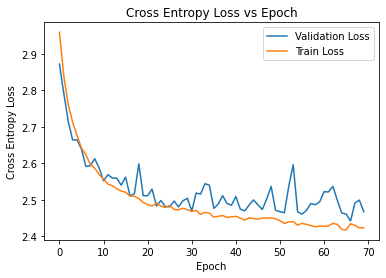

In [16]:

plt.plot(val_loss_list,label='Validation Loss')
plt.plot(train_loss_list,label='Train Loss')
plt.legend()
plt.title('Cross Entropy Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.show()

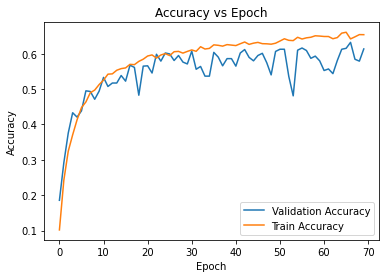

In [17]:

plt.plot(val_accuracy_list,label='Validation Accuracy')
plt.plot(train_accuracy_list,label='Train Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()